In [1]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U


In [2]:
import pandas as pd
df = pd.read_csv('data.csv')
df.head()

,text,label
0,He got the job only because of his race.,racist
1,People of that race are always so loud.,racist
2,I wouldn't want someone of that race as my nei...,racist
3,She acts that way because of her race.,racist
4,Their race is always involved in crime.,racist


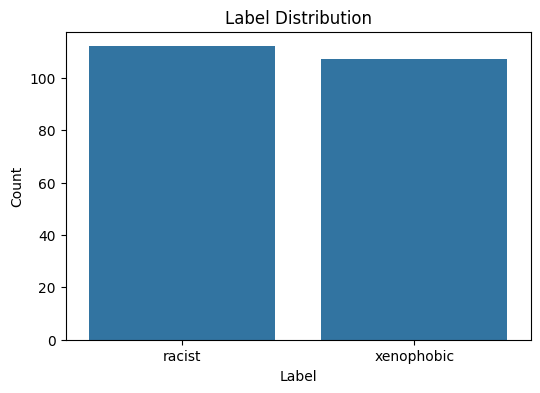

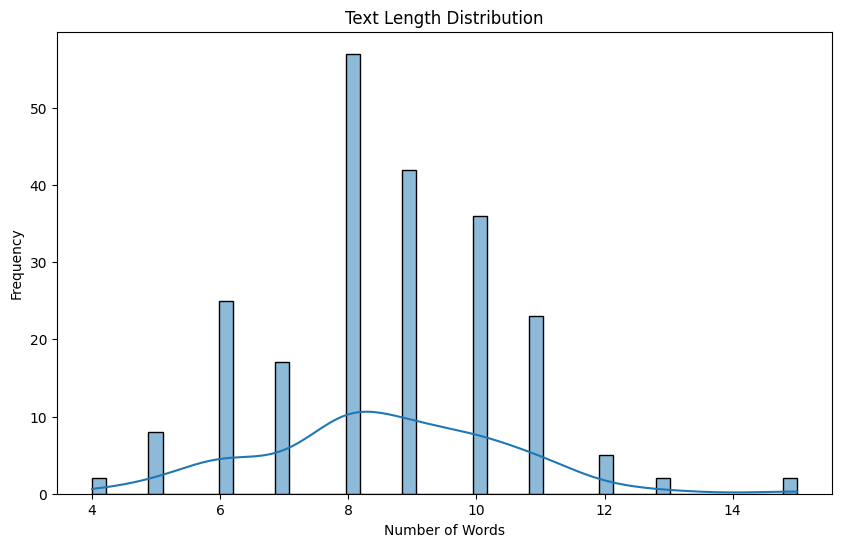

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of labels
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Calculate the length of each text
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
def process_data(row):

    text = row['text']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=256)

    label = 0
    if row['label'] == 'racist':
        label += 1

    encodings['labels'] = label
    encodings['texts'] = text

    return encodings

In [6]:
print(process_data({
    'text': 'nigga',
    'label': 'racist'
}))

{'input_ids': [101, 9152, 23033, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
processed_data = []

for i in range(len(df[:])):
    processed_data.append(process_data(df.iloc[i]))

In [8]:
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame(processed_data)

train_df, valid_df = train_test_split(
    new_df,
    test_size=0.2,
    random_state=2022
)

In [9]:
import pyarrow as pa
from datasets import Dataset

train_hg = Dataset(pa.Table.from_pandas(train_df))
valid_hg = Dataset(pa.Table.from_pandas(valid_df))

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="./result", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.036539
2,No log,0.002717
3,No log,0.007595


TrainOutput(global_step=66, training_loss=0.1103708671801018, metrics={'train_runtime': 26.9632, 'train_samples_per_second': 19.471, 'train_steps_per_second': 2.448, 'total_flos': 69066652032000.0, 'train_loss': 0.1103708671801018, 'epoch': 3.0})

In [13]:
trainer.evaluate()


{'eval_loss': 0.007595044560730457,
 'eval_runtime': 0.5976,
 'eval_samples_per_second': 73.63,
 'eval_steps_per_second': 10.04,
 'epoch': 3.0}

In [14]:
model.save_pretrained('./model/')


In [15]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_model = AutoModelForSequenceClassification.from_pretrained('./model/').to(device)
new_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def get_prediction(text):
    encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = new_model(**encoding)

    logits = outputs.logits
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sigmoid = torch.nn.Sigmoid()
    print(sigmoid)
    probs = sigmoid(logits.squeeze().cpu())
    probs = probs.detach().numpy()
    label = np.argmax(probs, axis=-1)

    if label == 1:
        return {
            'label': 'racist',
            'probability': probs[1]
        }
    else:
        return {
            'label': 'xenophobic',
            'probability': probs[0]
        }

In [19]:
get_prediction("nigga")


Sigmoid()


{'label': 'racist', 'probability': 0.87540025}